# Proposed model: CNN + Handcrafted + LSTM
In this notebook I will implement the proposed network architecture to detect Deepfake videos on the Celeb DF dataset. The proposed model architecture is showed in the figure below.

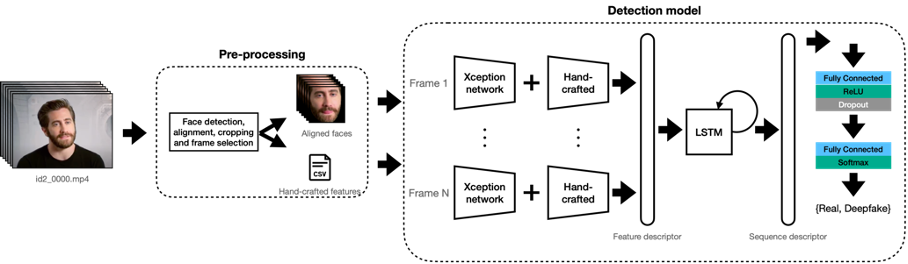

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.utils import to_categorical, plot_model
from keras.applications import Xception
from keras import layers, models, losses, optimizers, metrics
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os
import time
import pickle
import sys
sys.path.insert(0, '/content/drive/MyDrive/Thesis Deepfakes 2021/')

from preprocess import load_filepaths, load_batch_hand, load_batch_aligned

tf.test.gpu_device_name()

Mounted at /content/drive


''

## 1. Load data

In [2]:
# Load filepaths for handcrafted and aligned data
x_train, y_train, x_val, y_val, x_test, y_test = load_filepaths()

x_train = 820 , y_train (820, 2)
x_val = 180 , y_val (180, 2)
x_test = 160 , y_test (160, 2)


## 2. Define model: CNN + handcrafted + LSTM

This is kind of a hybrid model that both incorporates features extracted from a CNN as well as hand-crafted features. Architecture is almost the same as for the baseline model, however, the deep and hand-crafted features are concetenated after feature extraction.

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input CNN (InputLayer)          [(None, 5, 150, 150, 0                                            
__________________________________________________________________________________________________
CNN (TimeDistributed)           (None, 5, 2048)      20861480    Input CNN[0][0]                  
__________________________________________________________________________________________________
Input hand (InputLayer)         [(None, 5, 84)]      0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 5, 256)       524544      CNN[0][0]                        
_____________________________

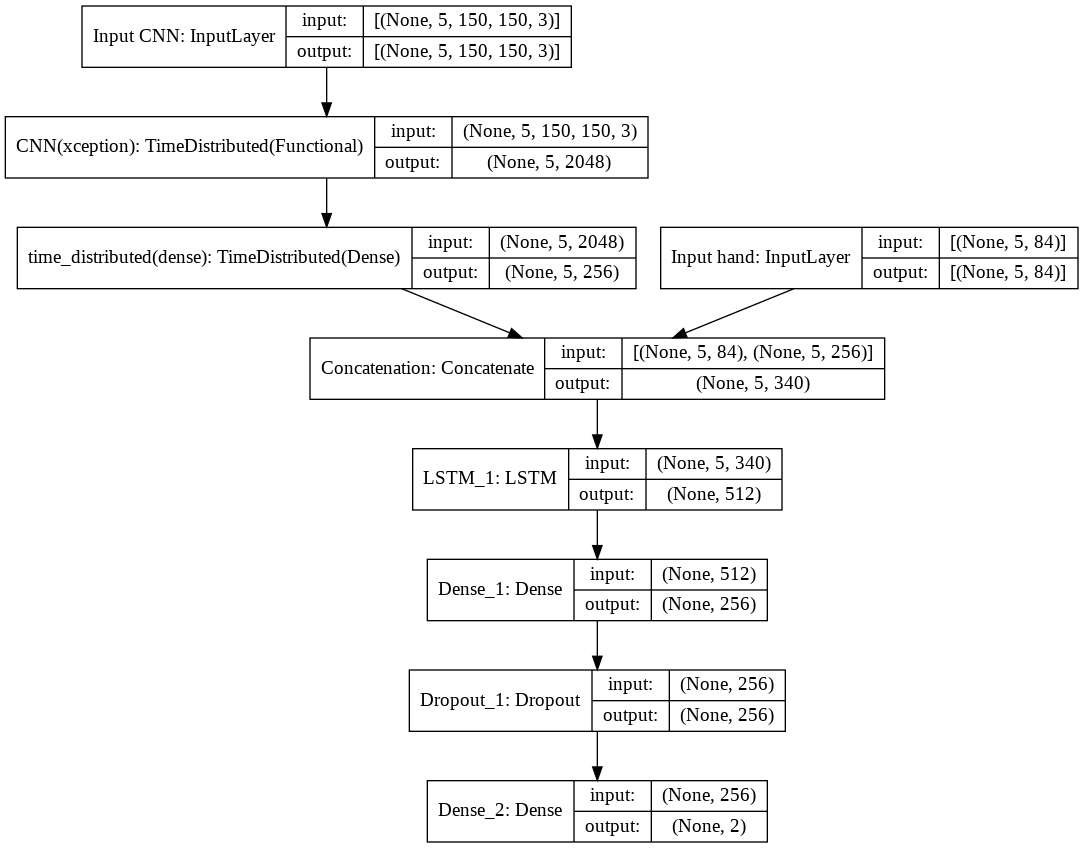

In [ ]:
# Define proposed model here
def proposed_model(n_frames):
  # Define CNN model: Xception pre-trained on ImageNet
  cnn = Xception(
      weights='imagenet',
      input_shape=(150,150,3),
      include_top=False,
      pooling='avg')
  
  # Freeze the layers of the xception network
  cnn.trainable = False

  # Define first part model: CNN + hand-crafted features model
  cnn_input = layers.Input(shape=(n_frames, 150, 150, 3), name='Input CNN')
  cnn_lay = layers.TimeDistributed(cnn, name='CNN')(cnn_input)
  cnn_lay = layers.TimeDistributed(layers.Dense(256))(cnn_lay)

  feats_input = layers.Input(shape=(n_frames, 84), name='Input hand')

  # Merge deep and hand-crafted features
  merged = layers.concatenate([feats_input, cnn_lay], name='Concatenation')

  # Define final model on top of deep and hand-crafted features
  final = layers.LSTM(512, name='LSTM_1')(merged)
  final = layers.Dense(256, activation='relu', name='Dense_1')(final)
  final = layers.Dropout(0.5, name='Dropout_1')(final)
  output = layers.Dense(2, activation='softmax', name='Dense_2')(final)

  model = models.Model(inputs=[feats_input, cnn_input], outputs=output)

  return model

model = proposed_model(n_frames=5)
model.summary()
plot_model(model, 'proposed_model.png', show_shapes=True, show_layer_names=True)

## 3. Train the model

In [ ]:
# Speed up the training step with tf.function: https://keras.io/guides/writing_a_training_loop_from_scratch/
@tf.function
def train_step(x, y, model, loss_fn, optimizer, train_acc_metric, train_auc_metric):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, y_pred)
    train_auc_metric.update_state(y, y_pred)
    return loss_value

@tf.function
def val_step(x, y, model, loss_fn, val_acc_metric, val_auc_metric):
    y_pred = model(x, training=False)
    loss_value = loss_fn(y, y_pred)
    val_acc_metric.update_state(y, y_pred)
    val_auc_metric.update_state(y, y_pred)
    return loss_value

def train_model(model, x_train, y_train, x_val, y_val, batch_size, num_epochs, learning_rate=0.00001, n_frames=5, equal_interval=0, experiment='test'):
  print("[INFO] Training...")
  total_time = time.time()

  # Define loss function and optimzer, and metrics
  loss_fn = losses.CategoricalCrossentropy(from_logits=True)
  optimizer = optimizers.Adam(lr=learning_rate)
  train_acc_metric = metrics.CategoricalAccuracy()
  train_auc_metric = metrics.AUC()
  val_acc_metric = metrics.CategoricalAccuracy()
  val_auc_metric = metrics.AUC()

  train_loss = []
  train_accs = []
  train_aucs = []
  val_loss = []
  val_accs = []
  val_aucs = []

  # Create indices of x_train list to loop over
  train_batch_indices = list(range(len(x_train)//batch_size))

  # Create indices of x_val list to loop over
  val_batch_indices = list(range(len(x_val)//batch_size))

  print('[INFO] \tEpoch \tBatch \t\tLoss')
  # Looping over all data and train model
  for epoch in range(num_epochs):
    start_time = time.time()

    ##### TRAINING LOOP #####
    for b_idx in train_batch_indices:
      # Create training batch
      batch_start = b_idx * batch_size # 0*64
      batch_end = (b_idx + 1) * batch_size # 1*64

      # Create databatch with filepaths
      x_batch_train_filenames = x_train[batch_start : batch_end]
      y_batch_train = y_train[batch_start : batch_end]
      
      # Load actual hand-crafted features and aligned images for cnn
      x_batch_train_hand = load_batch_hand(x_batch_train_filenames, y_batch_train, n_frames=n_frames, equal_interval=equal_interval)
      x_batch_train_aligned = load_batch_aligned(x_batch_train_filenames, y_batch_train, n_frames=n_frames, equal_interval=equal_interval)

      # Use train_step function to speed up process
      loss_value = train_step([x_batch_train_hand, x_batch_train_aligned], y_batch_train, model, loss_fn, optimizer, train_acc_metric, train_auc_metric)

      print('[INFO] \t{} \t{}/{} \t\t{:.4f}'.format(epoch+1, b_idx+1, len(train_batch_indices), loss_value))

    # Add training loss and accuracy at the end of each epoch to array and reset training metrics
    train_loss.append(loss_value.numpy())
    train_accs.append(train_acc_metric.result().numpy())
    train_aucs.append(train_auc_metric.result().numpy())
    train_acc_metric.reset_states()
    train_auc_metric.reset_states()
    print('[INFO] Training accuracy over epoch {}: {:.4f}'.format(epoch+1, train_accs[-1]))

    ##### VALIDATION LOOP #####
    for b_idx in val_batch_indices:
      # Create validation batch
      batch_start = b_idx * batch_size
      batch_end = (b_idx + 1) * batch_size
      x_batch_val_filenames = x_val[batch_start : batch_end]
      y_batch_val = y_val[batch_start : batch_end]

      # Load validation data for batch
      x_batch_val_hand = load_batch_hand(x_batch_val_filenames, y_batch_val, n_frames=n_frames, equal_interval=equal_interval)
      x_batch_val_aligned = load_batch_aligned(x_batch_val_filenames, y_batch_val, n_frames=n_frames, equal_interval=equal_interval)

      # Compute loss value through val_step function
      loss_value = val_step([x_batch_val_hand, x_batch_val_aligned], y_batch_val, model, loss_fn, val_acc_metric, val_auc_metric)

    # Add validation loss and accuracy at the end of each epoch to array and reset validation metrics
    val_loss.append(loss_value.numpy())
    val_accs.append(val_acc_metric.result().numpy())
    val_aucs.append(val_auc_metric.result().numpy())
    val_acc_metric.reset_states()
    val_auc_metric.reset_states()
    print('[INFO] Validation accuracy over epoch {}: {:.4f}'.format(epoch+1, val_accs[-1]))
    
    # Check every 10 epochs the model and save model and weights
    if (epoch+1) % 5 == 0:
      results = np.array([train_loss, train_accs, train_aucs, val_loss, val_accs, val_aucs])
      model.save(f'/content/drive/My Drive/Thesis Deepfakes 2021/tmp/results_ex{experiment}_model.h5')
      np.savetxt(f'/content/drive/My Drive/Thesis Deepfakes 2021/tmp/results_ex{experiment}.txt', results)
      print('[INFO] Model and model weights are saved')

    print('[INFO] Time taken for epoch {}: {:.2f} minutes'.format(epoch+1, (time.time() - start_time)/60 ))

  print('[INFO] Total execution time is {:.2f} hours'.format( (time.time() - total_time)/60/60 ))

  return train_loss, train_accs, train_aucs, val_loss, val_accs, val_aucs, model


In [ ]:
# Subset for faster learning
#x_train = x_train[:16]
#y_train = y_train[:16]
#x_val = x_val[:16]
#y_val = y_val[:16]

# Parameters NEXT TIME SAVE RESULTS AS 7.1.1
BATCH_SIZE = 16
NUM_EPOCHS = 20
N_FRAMES = 10
EQUAL_INTERVAL = 15
EXPERIMENT = '10.2'

# Construct model and train
model = proposed_model(n_frames=N_FRAMES)

train_loss, train_accs, train_aucs, val_loss, val_accs, val_aucs, model = train_model(model, x_train, y_train, x_val, y_val, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

[INFO] Training...
[INFO] 	Epoch 	Batch 		Loss
[INFO] 	1 	1/51 		0.6872
[INFO] 	1 	2/51 		0.5866
[INFO] 	1 	3/51 		0.6573
[INFO] 	1 	4/51 		0.7077
[INFO] 	1 	5/51 		0.6684
[INFO] 	1 	6/51 		0.7346
[INFO] 	1 	7/51 		0.7008
[INFO] 	1 	8/51 		0.7592
[INFO] 	1 	9/51 		0.5897
[INFO] 	1 	10/51 		0.7093
[INFO] 	1 	11/51 		0.8533
[INFO] 	1 	12/51 		0.8022
[INFO] 	1 	13/51 		0.6042
[INFO] 	1 	14/51 		0.6743
[INFO] 	1 	15/51 		0.7368
[INFO] 	1 	16/51 		0.7476
[INFO] 	1 	17/51 		0.7784
[INFO] 	1 	18/51 		0.6844
[INFO] 	1 	19/51 		0.6534
[INFO] 	1 	20/51 		0.7143
[INFO] 	1 	21/51 		0.6415
[INFO] 	1 	22/51 		0.6630
[INFO] 	1 	23/51 		0.7053
[INFO] 	1 	24/51 		0.7501
[INFO] 	1 	25/51 		0.7298
[INFO] 	1 	26/51 		0.7581
[INFO] 	1 	27/51 		0.7017
[INFO] 	1 	28/51 		0.6708
[INFO] 	1 	29/51 		0.6783
[INFO] 	1 	30/51 		0.6104
[INFO] 	1 	31/51 		0.7136
[INFO] 	1 	32/51 		0.6299
[INFO] 	1 	33/51 		0.6647
[INFO] 	1 	34/51 		0.7221
[INFO] 	1 	35/51 		0.7212
[INFO] 	1 	36/51 		0.6248
[INFO] 	1 	37/51 		0.7211


## 4. Visualize and save results

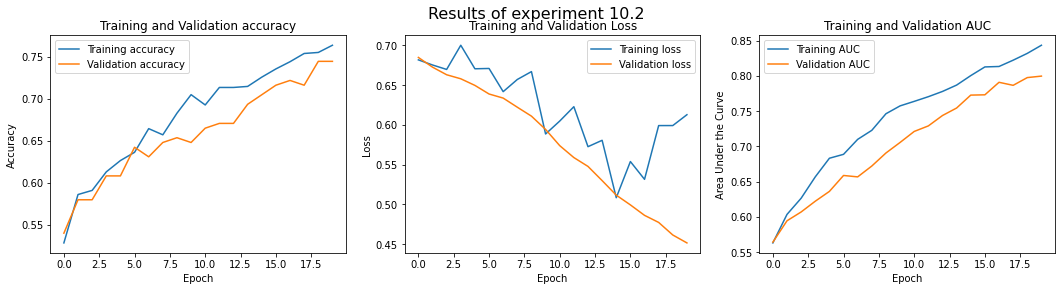

In [ ]:
# Save results in pickle file
results = [train_loss, train_accs, train_aucs, val_loss, val_accs, val_aucs]
with open(f'/content/drive/My Drive/Thesis Deepfakes 2021/tmp/results_ex{EXPERIMENT}.pickle', 'wb') as f:
  pickle.dump(results, f)

# Visualize and save plot
plt.figure(figsize=(18,4))
plt.suptitle(f'Results of experiment {EXPERIMENT}', fontsize=16)

plt.subplot(1,3,1)
plt.title('Training and Validation accuracy')
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

plt.subplot(1,3,2)
plt.title('Training and Validation Loss')
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,3,3)
plt.title('Training and Validation AUC')
plt.plot(train_aucs)
plt.plot(val_aucs)
plt.xlabel('Epoch')
plt.ylabel('Area Under the Curve')
plt.legend(['Training AUC', 'Validation AUC'])

plt.savefig(f'/content/drive/My Drive/Thesis Deepfakes 2021/tmp/results_ex{EXPERIMENT}.png')
plt.show()

In [ ]:
# Print last training accuracy and auc
print('Last training accuracy = {:.3f}'.format(train_accs[-1]))
print('Last training auc = \t {:.3f}'.format(train_aucs[-1]))

print('Last validation accuracy = {:.3f}'.format(val_accs[-1]))
print('Last validation auc = \t {:.3f}'.format(val_aucs[-1]))

# Print maximum accuracy and auc
print('Max training accuracy =', max(train_accs))
print('Max training auc = \t', max(train_aucs))

print('Max validation accuracy =', max(val_accs))
print('Max validation auc = \t', max(val_aucs))

print('Het duurt nu al 3 uur en 5 min Zal nog wel hoelang duren...')
print('alleen load_batch_aligned duurt heel erg lang, hoe dit versnellen???')
print('Duurt lang.sdlkfjldsfjsskadIHOPE IT WORKSsddhhhhhhhghgdsddddddddddsdslddf.. ')

Last training accuracy = 0.763
Last training auc = 	 0.843
Last validation accuracy = 0.744
Last validation auc = 	 0.800
Max training accuracy = 0.76348037
Max training auc = 	 0.843373
Max validation accuracy = 0.7443182
Max validation auc = 	 0.7995868
Het duurt nu al 3 uur en 5 min Zal nog wel hoelang duren...
alleen load_batch_aligned duurt heel erg lang, hoe dit versnellen???
Duurt lang.sdlkfjldsfjsskadIHOPE IT WORKSsddhhhhhhhghgdsddddddddddsdslddf.. 


## 5. Test model's performance

In [2]:
from sklearn.metrics import confusion_matrix
#import seaborn as sn

def evaluate_model(model, x_test, y_test, batch_size, n_frames=5, equal_interval=0, experiment='test'):
  start_time = time.time()

  # Define evaluation metrics
  test_acc_metric = metrics.CategoricalAccuracy()
  test_auc_metric = metrics.AUC()

  # Create indices of x_test list to loop over
  test_batch_indices = list(range(len(x_test)//batch_size))
  predictions = []
  probas = []

  ##### TEST LOOP #####
  for b_idx in test_batch_indices:
    # Create test batch
    batch_start = b_idx * batch_size
    batch_end = (b_idx + 1) * batch_size
    x_batch_test_filenames = x_test[batch_start : batch_end]
    y_batch_test = y_test[batch_start : batch_end]

    # Load test data for batch
    x_batch_test_hand = load_batch_hand(x_batch_test_filenames, y_batch_test, n_frames=n_frames, equal_interval=equal_interval)
    x_batch_test_aligned = load_batch_aligned(x_batch_test_filenames, y_batch_test, n_frames=n_frames, equal_interval=equal_interval)

    # Compute predictions and update metrics
    y_prob = model([x_batch_test_hand, x_batch_test_aligned], training=False)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_batch_test, axis=1)
    probas.append(y_prob)
    predictions.append(y_pred)
    test_acc_metric.update_state(y_batch_test, y_prob)
    test_auc_metric.update_state(y_batch_test, y_prob)

    print(f'[INFO] {b_idx+1} / {len(test_batch_indices)}')

  test_acc = round(test_acc_metric.result().numpy(), 3)
  test_auc = round(test_auc_metric.result().numpy(), 3)

  # Calculate confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.array(predictions).flatten())
  tn = cm[0][0]
  fp = cm[0][1]
  fn = cm[1][0]
  tp = cm[1][1]

  print('Confusion matrix', cm)

  # Calculate false postive rates and true positive rates
  probas = np.array(probas).reshape(len(x_test), 2)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test[:, 1], probas)

  print()
  print('Performances on test dataset')
  print(f'Accuracy: {test_acc}')
  print(f'AUC: {test_auc}')
  print(f'TP: {tp}')
  print(f'FP: {fp}')
  print(f'TN: {tn}')  
  print(f'FN: {fn}')

  print()

  print('Correctly Detected Deepfakes (True Negatives): ', tn)
  print('Deepfake Videos Incorrectly Detected (False Positives): ', fp)
  print('Deepfake Videos Missed (False Negatives): ', fn)
  print('Deepfake Videos Detected (True Positives): ', tp)
  print('Total Deepfake Videos: ', tn+fp+fn+tp)
  print()
  print('Time taken: {:.4f} seconds'.format((time.time() - start_time)))

  return test_acc, test_auc, predictions, tp, fp, tn, fn, fpr, tpr, cm

In [3]:
# Load data filepaths
x_train, y_train, x_val, y_val, x_test, y_test = load_filepaths()
#x_test = x_test[:32]
#y_test = y_test[:32]

BATCH_SIZE = 16
proposed_models = ['6.1', '7.1', '9.1', '10.2']

for EXPERIMENT in proposed_models:
  model = models.load_model(f'/content/drive/My Drive/Thesis Deepfakes 2021/tmp/results_ex{EXPERIMENT}_model.h5')
  print(f'Loaded in model proposed {EXPERIMENT}')

  if EXPERIMENT == '6.1':
    N_FRAMES = 10
    EQUAL_INTERVAL = 0
    acc_10, auc_10, pred_10, tp_10, fp_10, tn_10, fn_10, fpr_10, tpr_10, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    # plt.figure(figsize=(8,5))
    # sn.set(font_scale=1.4) # for label size
    # sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    # plt.savefig(f'/content/drive/My Drive/Thesis Deepfakes 2021/plots/CM_proposed_model{EXPERIMENT}.png')

  if EXPERIMENT == '7.1':
    N_FRAMES = 20
    EQUAL_INTERVAL = 0
    acc_20, auc_20, pred_20, tp_20, fp_20, tn_20, fn_20, fpr_20, tpr_20, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    # plt.figure(figsize=(8,5))
    # sn.set(font_scale=1.4) # for label size
    # sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    # plt.savefig(f'/content/drive/My Drive/Thesis Deepfakes 2021/plots/CM_proposed_model{EXPERIMENT}.png')

  if EXPERIMENT == '9.1':
    N_FRAMES = 5
    EQUAL_INTERVAL = 30
    acc_30, auc_30, pred_30, tp_30, fp_30, tn_30, fn_30, fpr_30, tpr_30, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    # plt.figure(figsize=(8,5))
    # sn.set(font_scale=1.4) # for label size
    # sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    # plt.savefig(f'/content/drive/My Drive/Thesis Deepfakes 2021/plots/CM_proposed_model{EXPERIMENT}.png')

  if EXPERIMENT == '10.2':
    N_FRAMES = 10
    EQUAL_INTERVAL = 15
    acc_15, auc_15, pred_15, tp_15, fp_15, tn_15, fn_15, fpr_15, tpr_15, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    # plt.figure(figsize=(8,5))
    # sn.set(font_scale=1.4) # for label size
    # sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    # plt.savefig(f'/content/drive/My Drive/Thesis Deepfakes 2021/plots/CM_proposed_model{EXPERIMENT}.png')


x_train = 820 , y_train (820, 2)
x_val = 180 , y_val (180, 2)
x_test = 160 , y_test (160, 2)
Loaded in model proposed 6.1
[INFO] 1 / 10
[INFO] 2 / 10
[INFO] 3 / 10
[INFO] 4 / 10
[INFO] 5 / 10
[INFO] 6 / 10
[INFO] 7 / 10
[INFO] 8 / 10
[INFO] 9 / 10
[INFO] 10 / 10
Confusion matrix [[52 28]
 [23 57]]

Performances on test dataset
Accuracy: 0.6809999942779541
AUC: 0.7450000047683716
TP: 57
FP: 28
TN: 52
FN: 23

Correctly Detected Deepfakes (True Negatives):  52
Deepfake Videos Incorrectly Detected (False Positives):  28
Deepfake Videos Missed (False Negatives):  23
Deepfake Videos Detected (True Positives):  57
Total Deepfake Videos:  160

Time taken: 1660.2569 seconds
Loaded in model proposed 7.1
[INFO] 1 / 10
[INFO] 2 / 10
[INFO] 3 / 10
[INFO] 4 / 10
[INFO] 5 / 10
[INFO] 6 / 10
[INFO] 7 / 10
[INFO] 8 / 10
[INFO] 9 / 10
[INFO] 10 / 10
Confusion matrix [[55 25]
 [19 61]]

Performances on test dataset
Accuracy: 0.7250000238418579
AUC: 0.8009999990463257
TP: 61
FP: 25
TN: 55
FN: 19

Correctl

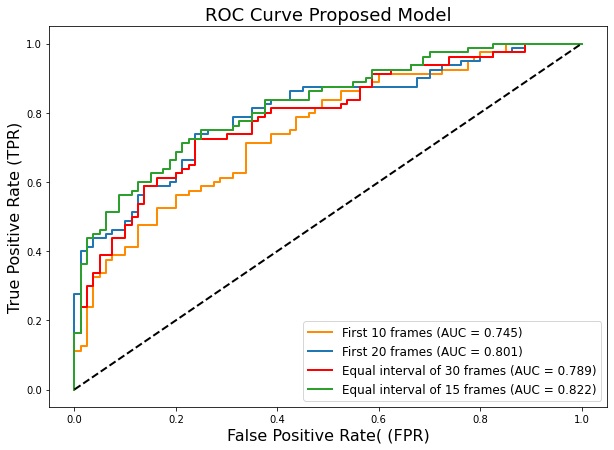

In [4]:
plt.figure(figsize=(10,7))
plt.plot(fpr_10, tpr_10, label='First 10 frames (AUC = {:.3f})'.format(auc_10), linewidth=2, color='darkorange')
plt.plot(fpr_20, tpr_20, label='First 20 frames (AUC = {:.3f})'.format(auc_20), linewidth=2, color='tab:blue')
plt.plot(fpr_30, tpr_30, label='Equal interval of 30 frames (AUC = {:.3f})'.format(auc_30), linewidth=2, color='red')
plt.plot(fpr_15, tpr_15, label='Equal interval of 15 frames (AUC = {:.3f})'.format(auc_15), linewidth=2, color='tab:green')
plt.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        linestyle='--', linewidth=2, color='black')
plt.title('ROC Curve Proposed Model', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=16)
plt.xlabel('False Positive Rate( (FPR)', fontsize=16)
plt.legend(fontsize=12)
plt.savefig('/content/drive/My Drive/Thesis Deepfakes 2021/plots/AUC_plot_proposed_model3')
plt.show()

In [ ]:
# VISUALIZE TEST RESULTS HERE
# ALSO SHOW ONE VIDEO FROM TEST DATA, WITH THE PREDICTION AND REAL LABELS!!

## 6. Cross-domain generalizability
In this section, the proposed model has been tested on the unseen FaceForensics++ dataset. This dataset consists of 1000 original videos that have been manipulated with four facial manipulation methosd such as FaceSwap, NeuralTextures, Face2Face and Deepfakes. As our model is trained on identity swapped videos, the model is first tested against the faceswap dataset of faceforensics++. As a result, the generalizability of the model has been tested on manipulated videos from the first generation, which normally exhibit more visual artifacts (source Dolhansky). Afterwards, the model is tested against other types of facial manipuations, to test the performance of the model on other facial tampared videos. 

## 7. Extra

In [ ]:
def find_index_handfeatures(filename):
  import pandas as pd 
  colms = []
  # Load an example file and show columns with index
  df = pd.read_csv('/content/drive/My Drive/Thesis Deepfakes 2021/data_sampled/real_hand/{}'.format(filename))
  for i, coln in enumerate(df):
    print(i, coln)
    colms.append(coln)

  return colms

In [ ]:
def network(frames=5):
  sequence = layers.Input(shape=(frames, 150,150,3))
  features = layers.Input(shape=(frames, 24))

  cnn = Xception(
      weights='imagenet',
      input_shape=(150,150,3),
      include_top=False,
      pooling='avg')
  
  cnn.trainable = False

  conv = models.Sequential()
  conv.add(layers.TimeDistributed(cnn))
  part1 = conv(sequence)

  merged = layers.concatenate([part1, features])

  # Define final model on top of deep and hand-crafted features
  final = layers.LSTM(512, name='LSTM_1')(merged)
  final = layers.Dense(256, activation='relu', name='Dense_1')(final)
  final = layers.Dropout(0.5, name='Dropout_1')(final)
  output = layers.Dense(2, activation='softmax', name='Dense_2')(final)

  model = models.Model(inputs=[sequence, features], outputs=[output])

  return model

In [ ]:
import plot_roc_curve, confusion_matrix, roc_curve

# Make now a AUC plot via tp, fn etc. See https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663
# Select positive predictions only
probas = np.array(predictions).reshape(160, 2)[:, 1]
print(len(probas))

# Convert prediction accordingly through thresholds
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


# Create list of True Positve Rates and False Positive Raters at varying thesholds
roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test[:, 1], preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])

tpr_values, fpr_values = zip(*roc_values)

print(len(tpr_values), len(fpr_values))